## Covid19 in Morocco - Data Analysis

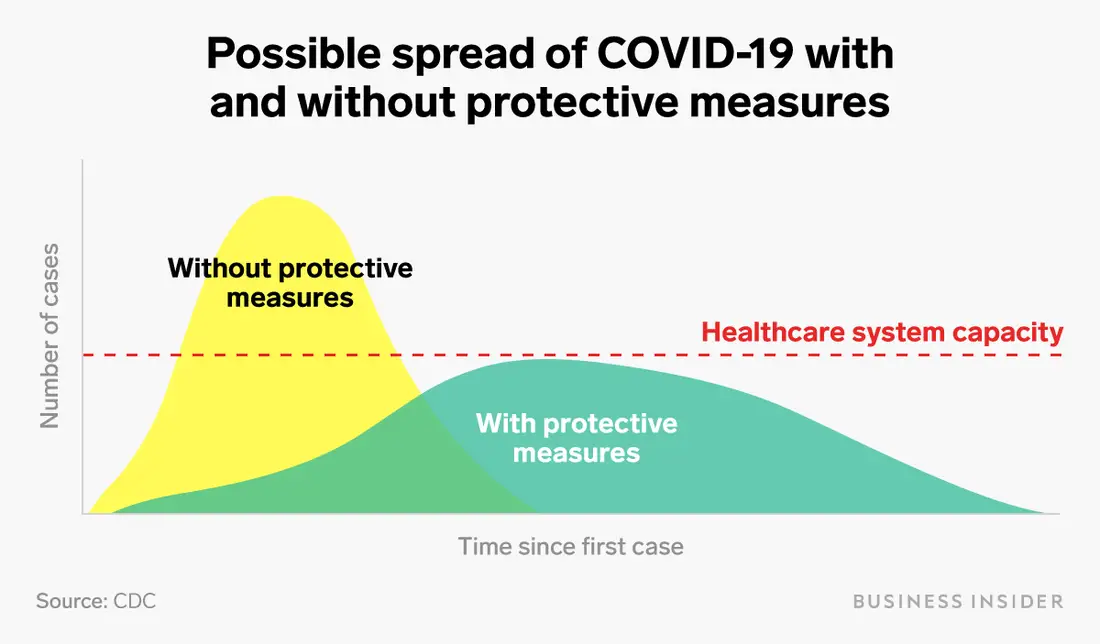

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Date & Time
from datetime import date, datetime, timedelta

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# plt.style.use('ggplot')
# sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')
font = {
    'weight' : 'bold',
    'size'   : 13
}
plt.rc('font', **font)

In [ ]:
url = '../input/moroccocoronavirus/corona_morocco.csv'
data = pd.read_csv(url, header='infer')
data.head()

In [ ]:
data.tail()

In [ ]:
data.info()
# data.get_dtype_counts()

In [ ]:
data["Date"] = pd.to_datetime(data['Date'], dayfirst=True)
data["Date"].dtype

In [ ]:
## Selecting rows with history data

data = data[data["Date"] <= pd.Timestamp(date.today())]
data.tail()

In [ ]:
# Feature Engineering
data["Tested"] = data["Confirmed"] + data["Excluded"]
data['Active'] = data['Confirmed'] - (data['Deaths'] + data['Recovered'])

In [ ]:
## Replace Missing Data
data.fillna(method='ffill', inplace=True)
data.fillna(value=0, inplace=True)

In [ ]:
title = "Covid-19 Morocco"

def lineplot(data, cols):
    """
    Line plot a list of variables with respect to date
    """
    f, ax = plt.subplots(1,1, figsize=(20, 8))
    for col in cols:
            g = sns.lineplot(x="Date", y=col, data=data, label=col)
    plt.xlabel('Date')
    plt.ylabel(f'Total Cumulative {title} cases')
    plt.title(f'Total Cumulative {title} cases')
    plt.xticks(rotation=45)
    plt.show();

lineplot(data, ['Confirmed', 'Recovered', 'Deaths'])

In [ ]:
## Plot of Confirmed, Tested, Excluded Cases
lineplot(data, ['Confirmed', 'Tested', 'Excluded'])

In [ ]:
## Plot of recovered and Death cases (Death Rate is critical)
lineplot(data, ['Recovered', 'Deaths'])

In [ ]:
## Plot of Active Cases
lineplot(data, ['Active'])

In [ ]:
## Todays histogram of cases by region
def plot_cases_by_region(DATE):
    dictionary = data[data.Date == DATE].to_dict(orient='records')[0]

    # Remove non-region keys
    entriesToRemove = ['Date', 'Confirmed', 'Tested', 'Excluded', 'Active', 'Deaths', 'Recovered']
    for k in entriesToRemove:
        dictionary.pop(k, None)

    ## Histogram of total cases by region
    ax = pd.Series(dictionary).plot(kind='bar', figsize=(20,8), title=f"Total Cases by region {DATE}")
    ax.set_xlabel("Region")
    ax.set_ylabel("Total Cases")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show();

In [ ]:
DATE = data.loc[10,:]['Date'].date()
plot_cases_by_region(DATE)

In [ ]:
yesterday = date.today() - timedelta(days=1)
plot_cases_by_region(yesterday)

In [ ]:
today = date.today()
plot_cases_by_region(today)

In [ ]:
REGIONS= ['Beni Mellal-Khenifra', 'Casablanca-Settat', 'Draa-Tafilalet',
          'Dakhla-Oued Ed-Dahab', 'Fes-Meknes', 'Guelmim-Oued Noun',
          'Laayoune-Sakia El Hamra', 'Marrakesh-Safi', 'Oriental',
          'Rabat-Sale-Kenitra', 'Souss-Massa', 'Tanger-Tetouan-Al Hoceima']

custom_palette = sns.color_palette("Paired", 12)

In [ ]:
plt.figure(figsize=(20, 8))
for i, col in enumerate(REGIONS):
    sns.lineplot(x='Date', y=col, data = data.iloc[17:], label=col, linewidth=2.5, color=custom_palette[i])

plt.title(f'Total Cumulative cases in each region of Morocco')
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.xticks(rotation=45)
plt.grid()
plt.legend();

In [ ]:
TodayData = data[data["Date"] == yesterday]

# Calculate Proportions
TodayData[REGIONS] = TodayData[REGIONS]/ TodayData['Confirmed'].tolist()[0]

# Plot Distribution of Confirmed Cases
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12)
TodayData[REGIONS].iloc[0, :].plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=81)
ax.set_ylabel('')
ax.set_xlabel('');

In [ ]:
# x = np.array(list(data.columns)[4:])
# y = np.array(TodayData.iloc[:,4:])[0]
# colors = ['yellowgreen','red','gold','lightskyblue','white','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
# porcent = 100. * y / y.sum()

# plt.figure(figsize=(18, 10))
# patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
# labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

# sort_legend = True
# if sort_legend:
#     patches, labels, dummy =  zip(*sorted(zip(patches, labels, y), key=lambda x: x[2], reverse=True))

# plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.), fontsize=8)
# plt.savefig('piechart.png', bbox_inches='tight');

In [ ]:
import folium 
import webbrowser

def MapTweetLocations(DATE):

    # Select Row
    row = data[data.Date == DATE]
    row = row[REGIONS].iloc[row.shape[0]-1,:]
    
    # Make Data as Dataframe
    df = {
        'latitude': [32.320296, 33.590000, 31.932124, 23.692847, 34.037120, 28.986355, 27.158507, 31.630000, 34.680000, 34.020000, 30.421440, 35.783621],
        'longitude': [-6.380926, -7.610000, -4.424149, -15.938255, -5.002964, -10.057375, -13.207878, -8.000000, -1.910000, -6.830000, -9.583039, -5.809643],
        'Region': row.index.to_list(),
        'Ncases': list(row.values)
    }
    df = pd.DataFrame.from_dict(df)

    # Create Map
    fig = folium.Figure(width=800, height=500)
    latitude, longitude = 29.852972, -12.763558
    CovidMap = folium.Map(location=[latitude, longitude], zoom_start=5)
    
    # Add Title
    title_html = f' <h3 align="center" style="font-size:20px"><b>Map of Covid-19 Cases in Morocco Regions By {DATE}</b></h3>'
    CovidMap.get_root().html.add_child(folium.Element(title_html))
    
    for lat, lon, Region, Ncases in zip(df['latitude'], df['longitude'], df['Region'], df['Ncases']):
        folium.CircleMarker(
            [lat, lon],
            radius=.1 * Ncases//50,
            popup = ('Region: ' + str(Region).capitalize() + '<br>'
                     'Cases: ' + str(Ncases) + '<br>'),
            color='red',
            fill_color = "red",
            fill=True,
            fill_opacity=0.7
            ).add_to(CovidMap)
        
    fig.add_child(CovidMap)
    return fig
    
DATE = date.today() - timedelta(days=15)
MapTweetLocations(DATE)

In [ ]:
DATE = date.today() - timedelta(days=2)
MapTweetLocations(DATE)

# -> To be continued ...

In [ ]:
# Regions with most new cases

## References:
* https://towardsdatascience.com/data-visualization-with-python-folium-maps-a74231de9ef7
* 
